# Visualising Score & Schedules of the Diffusion Model


In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "jax"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import timeit

import keras
import bayesflow as bf
from tqdm import tqdm

from scipy.stats import norm
sech = lambda x: 1 / np.cosh(x)

INFO:2025-10-27 10:45:16,796:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:bayesflow:Using backend 'jax'


## Simulator<a class="anchor" id="simulator"></a>

In [2]:
def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [3]:
simulator = bf.make_simulator([theta_prior, forward_model])

In [4]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
)

# Training

In [5]:
num_training_batches = 256
num_validation_sets = 300
batch_size = 128
epochs = 1000

In [6]:
training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

In [7]:
from bayesflow.networks.diffusion_model import EDMNoiseSchedule

In [8]:
# import math
# from typing import Literal
#
# from keras import ops
#
# from bayesflow.types import Tensor
# from bayesflow.utils.serialization import deserialize, serializable
# from bayesflow.networks.diffusion_model.schedules import NoiseSchedule
#
# # disable module check, use potential module after moving from experimental
# @serializable("bayesflow.networks", disable_module_check=True)
# class TrigFlowNoiseSchedule(NoiseSchedule):
#     """TrigFlow noise schedule for diffusion models. This schedule is based on [1].
#
#     A continuous-time noise schedule that uses trigonometric functions to define the log signal-to-noise.
#
#     [1] Lu, C., & Song, Y. (2025). Simplifying, Stabilizing and Scaling Continuous-Time Consistency Models
#     """
#
#     def __init__(
#         self,
#         target_std: float = 1.0,
#         weighting: Literal["sigmoid", "likelihood_weighting"] = "sigmoid",
#     ):
#         """
#         Initialize the cosine noise schedule.
#
#         Parameters
#         ----------
#         target_std : float, optional
#             The target standard deviation of the noise at the end of the diffusion process. Default is
#             1.0, should be the same as the standard deviation of the target at t=0.
#         weighting : Literal["sigmoid", "likelihood_weighting"], optional
#             The type of weighting function to use for the noise schedule. Default is "sigmoid".
#         """
#         super().__init__(name="trig_flow_noise_schedule", variance_type="preserving", weighting=weighting)
#         self.target_std = target_std
#         self._weighting = weighting
#
#         self._t_min = 0 + 1e-5
#         self._t_max = math.pi / 2
#
#         self.log_snr_max = self.get_log_snr(ops.convert_to_tensor(0.0), training=False)
#         self.log_snr_min = self.get_log_snr(ops.convert_to_tensor(1.0), training=False)
#
#     def _truncated_t(self, t: Tensor) -> Tensor:
#         return self._t_min + (self._t_max - self._t_min) * t
#
#     def get_alpha_sigma(self, log_snr_t: Tensor) -> tuple[Tensor, Tensor]:
#         """Get alpha and sigma for a given log signal-to-noise ratio (lambda)."""
#         t = self.get_t_from_log_snr(log_snr_t=log_snr_t, training=False)
#
#         alpha = ops.cos(t)
#         sigma = ops.sin(t) * self.target_std
#         return alpha, sigma
#
#     def get_log_snr(self, t: Tensor | float, training: bool) -> Tensor:
#         """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
#         t_trunc = self._truncated_t(t)
#         return ops.log(ops.cos(t_trunc) ** 2 / (ops.sin(t_trunc) ** 2 * self.target_std))
#
#     def get_t_from_log_snr(self, log_snr_t: Tensor | float, training: bool) -> Tensor:
#         """Get the diffusion time (t) from the log signal-to-noise ratio (lambda)."""
#         return ops.arcsin(1 / ops.sqrt(1 + self.target_std * ops.exp(log_snr_t)))
#
#     def derivative_log_snr(self, log_snr_t: Tensor, training: bool) -> Tensor:
#         """Compute d/dt log(1 + e^(-snr(t))), which is used for the reverse SDE."""
#         t = self.get_t_from_log_snr(log_snr_t=log_snr_t, training=training)
#
#         # Compute the truncated time t_trunc
#         t_trunc = self._truncated_t(t)
#         dsnr_dx = -2 / (ops.sin(t_trunc) * ops.cos(t_trunc))
#
#         # Using the chain rule on f(t) = log(1 + e^(-snr(t))):
#         # f'(t) = - (e^{-snr(t)} / (1 + e^{-snr(t)})) * dsnr_dt
#         dsnr_dt = dsnr_dx * (self._t_max - self._t_min)
#         factor = ops.exp(-log_snr_t) / (1 + ops.exp(-log_snr_t))
#         return -factor * dsnr_dt
#
#     # def get_weights_for_snr(self, log_snr_t: Tensor) -> Tensor:
#     #     alpha, sigma = self.get_alpha_sigma(log_snr_t)
#     #     velocity_weighting = 1 / (alpha** 2 * (ops.exp(-log_snr_t) + 1)**2)
#     #
#     #     additional_weights = super().get_weights_for_snr(log_snr_t=log_snr_t)
#     #     return velocity_weighting * additional_weights
#
#     def get_config(self):
#         config = {
#             "target_std": self.target_std,
#             "weighting": self._weighting,
#         }
#         return config
#
#     @classmethod
#     def from_config(cls, config, custom_objects=None):
#         return cls(**deserialize(config, custom_objects=custom_objects))


In [9]:
workflows = {}

for noise_schedule in ['cosine', 'edm', 'edm_ve']:
    diffusion_model_workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        inference_network = bf.networks.DiffusionModel(
            noise_schedule=noise_schedule if noise_schedule != 'edm_ve' else EDMNoiseSchedule(variance_type='exploding'),
            prediction_type='velocity' if noise_schedule == 'cosine' else 'F',
        ),
    )
    workflows['diffusion_model_'+noise_schedule] = diffusion_model_workflow

for ot in [False, True]:
    name = "flow_matching_ot" if ot else "flow_matching"
    for time_sampling_alpha in [0, -0.6]:
        if time_sampling_alpha != 0:
            continue
            name += '_pl'
        flow_matching_workflow = bf.BasicWorkflow(
            simulator=simulator,
            adapter=adapter,
            inference_network = bf.networks.FlowMatching(
                use_optimal_transport=ot,
                time_power_law_alpha=-0.6
            ),
        )
        workflows[name] = flow_matching_workflow

# consistency_workflow = bf.BasicWorkflow(
#     simulator=simulator,
#     adapter=adapter,
#     inference_network = bf.networks.ConsistencyModel(total_steps=epochs*batch_size),
# )
# workflows['discrete_consistency'] = consistency_workflow

stable_consistency_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.experimental.StableConsistencyModel(embed_dim=2),
)
workflows['stable_consistency'] = stable_consistency_workflow

In [10]:
for name, workflow in workflows.items():
    if os.path.exists('models/two_moons_'+name+'.keras'):
        print(f"Loading {name} from disk")
        workflow.fit_offline(  # otherwise some building steps are not executed
            training_data,
            epochs=1,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=0
        )
        workflow.approximator = keras.saving.load_model('models/two_moons_'+name+'.keras')
        continue

    print(f"Training {name}...")
    start = timeit.default_timer()
    workflow.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2
    )
    workflow.approximator.save('models/two_moons_'+name+'.keras')
    end = timeit.default_timer()
    print(f"Trained {name} in {end - start:.2f} seconds")

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Loading diffusion_model_cosine from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Loading diffusion_model_edm from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Loading diffusion_model_edm_ve from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Loading flow_matching from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Loading flow_matching_ot from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Training stable_consistency...
Epoch 1/1000
256/256 - 3s - 12ms/step - loss: -1.6666e-01 - val_loss: -3.9160e-01
Epoch 2/1000
256/256 - 2s - 7ms/step - loss: -4.1585e-01 - val_loss: -5.3251e-01
Epoch 3/1000
256/256 - 2s - 7ms/step - loss: -5.6002e-01 - val_loss: -7.2464e-01
Epoch 4/1000
256/256 - 2s - 7ms/step - loss: -6.6608e-01 - val_loss: -8.0242e-01
Epoch 5/1000
256/256 - 2s - 7ms/step - loss: -7.3309e-01 - val_loss: -8.4837e-01
Epoch 6/1000
256/256 - 2s - 7ms/step - loss: -7.8620e-01 - val_loss: -8.7750e-01
Epoch 7/1000
256/256 - 2s - 7ms/step - loss: -8.1257e-01 - val_loss: -8.9858e-01
Epoch 8/1000
256/256 - 2s - 7ms/step - loss: -8.4254e-01 - val_loss: -9.4901e-01
Epoch 9/1000
256/256 - 2s - 7ms/step - loss: -8.7406e-01 - val_loss: -9.5301e-01
Epoch 10/1000
256/256 - 2s - 7ms/step - loss: -8.8981e-01 - val_loss: -9.9054e-01
Epoch 11/1000
256/256 - 2s - 7ms/step - loss: -9.0639e-01 - val_loss: -9.8168e-01
Epoch 12/1000
256/256 - 2s - 7ms/step - loss: -9.1710e-01 - val_loss: -1.00

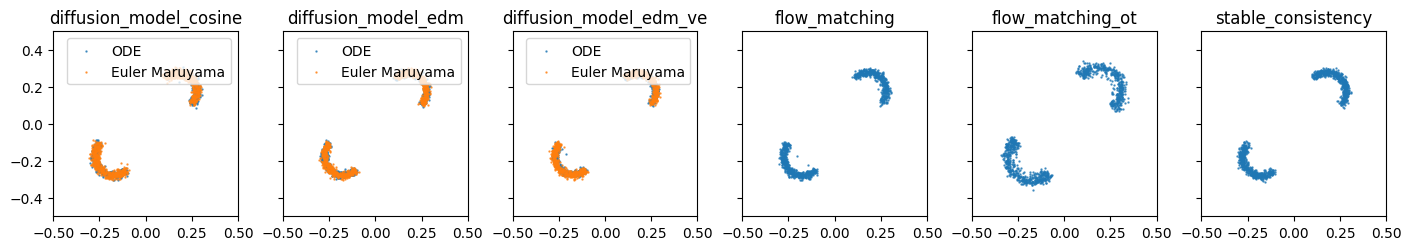

In [11]:
fig, ax = plt.subplots(ncols=len(workflows), figsize=(14, 5), layout='constrained', sharey=True, sharex=True)
if len(workflows) == 1:
    ax = [ax]
for i, (name, workflow) in enumerate(workflows.items()):
    samples = workflow.sample(num_samples=1000, conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
    ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="ODE")

    if name.split('_')[0] == 'diffusion':
        samples = workflow.sample(num_samples=1000, method="euler_maruyama",
                                  conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
        ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="Euler Maruyama")
        ax[i].legend(loc="upper right")

    ax[i].set_title(name)
    ax[i].set_aspect('equal')
ax[-1].set_xlim([-0.5, 0.5])
ax[-1].set_ylim([-0.5, 0.5])
plt.show()

# Visualizing the Trajectory

In [ ]:
def euler_backward_like(workflow, conditions, x0=None, steps=200, stochastic_solver=False):
    num_samples = 1  # not sure if the code would work with more, but not needed
    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, num_samples, *keras.ops.shape(inference_conditions)[2:])
    )

    if workflow.approximator.inference_network.name.split('_')[0] == 'flow':
        t_start, t_end = 0.0, 1.0
    elif workflow.approximator.inference_network.name.split('_')[0] == 'diffusion':
        t_start, t_end = 1.0, 0.0
    else:
        raise ValueError("Unknown inference network type")

    dt = (t_end - t_start) / steps  # negative if integrating toward 0
    if x0 is not None:
        x = x0
    else:
        # sample from the base distribution
        x = workflow.approximator.inference_network.base_distribution.sample((1, num_samples))
    t = float(t_start)

    traj = []
    vels = []
    for k in range(steps):
        traj.append(keras.ops.convert_to_numpy(x))
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
            if stochastic_solver:
                diff_curr = workflow.approximator.inference_network.diffusion_term(
                    xz=x, time=t, training=False
                )
                noise = keras.random.normal(keras.ops.shape(x), dtype=keras.ops.dtype(x)) * np.sqrt(np.abs(dt))
                x = x + diff_curr * noise

        x = x + dt * v_curr
        t = t + dt
        vels.append(keras.ops.convert_to_numpy(v_curr))

    traj = np.stack(traj, axis=0)      # shape [steps+1, batch, num_samples, dims]
    vels = np.stack(vels, axis=0)      # shape [steps,   batch, num_samples, dims]
    times = np.linspace(t_start, t_end, steps+1, dtype=np.float32)

    traj =  workflow.approximator.standardize_layers["inference_variables"](traj, forward=False)
    return traj, vels, times

In [ ]:
x0 = workflows[list(workflows.keys())[0]].approximator.inference_network.base_distribution.sample((1, 1)) * 0
conditions = {"x":np.array([[0.0, 0.0]], dtype=np.float32)}

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(workflows), figsize=(3*len(workflows), 4),
                       layout='constrained', sharey='row', sharex='row')
for i, (name, workflow) in enumerate(workflows.items()):
    traj, vels, times = euler_backward_like(
        workflow, x0=x0, conditions=conditions, steps=200, stochastic_solver=False
    )
    traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
    vel_norm = np.linalg.norm(vels, axis=-1)
    ax[0, i].plot(traj[:, 0], traj[:, 1], color='black', label="Trajectory" if i == 0 else None)
    ax[0, i].scatter(traj[0, 0], traj[0, 1], s=30, marker='o', label='start' if i == 0 else None, color='black') # start
    #ax[0, i].scatter(traj[-1, 0], traj[-1, 1], s=30, marker='x', label='end' if i == 0 else None, color='black') # end

    samples = workflow.sample(num_samples=1000, conditions=conditions)
    ax[0, i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.75,
                     color='darkviolet', label="Posterior Samples" if i == 0 else None)

    ax[1, i].plot(times[:-1], vel_norm)
    #ax[1, i].set_title("Velocity norm over time")
    ax[1, i].set_xlabel("time")

    ax[0, i].set_title(name)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.1, 0.85))
ax[0, 0].set_ylabel("y")
ax[0, -1].set_xlim([-0.5, 0.5])
ax[0, -1].set_ylim([-0.5, 0.5])
ax[1, 0].set_ylabel("||v||")
plt.show()

In [ ]:
n_trajectories = 15
n_sde_averages = 1
colors = [
    "#E7298A",  # magenta pink
    "#7570B3",  # muted purple
    "#1B9E77",  # teal green
    "#D95F02",  # deep orange
]

In [ ]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.stats import qmc
from shapely.geometry import MultiPoint

def title_and_color(name, is_sde, colors):
    if name.split('_')[0] == 'diffusion':
        kind = name.split('diffusion_model_')[1]
        if kind == 'edm':
            title = 'EDM VP'
            _color = colors[0]
        elif kind == 'edm_ve':
            title = 'EDM VE'
            _color = colors[0]
        else:
            title = kind.title()
            _color = colors[1]
    else:
        if name == 'flow_matching_ot':
            title = 'Flow Matching OT'
            _color = colors[2]
        else:
            title = 'Flow Matching'
            _color = colors[2]
    if is_sde:
        title = f"{title} (SDE)"
    return title, _color


def plot_density(ax, samples, xlim, ylim, bins=250, smooth_sigma=1):
    if samples is None or len(samples) == 0:
        return
    H, xedges, yedges = np.histogram2d(
        samples[:, 0], samples[:, 1],
        bins=bins, range=[xlim, ylim]
    )
     # smooth counts
    H = gaussian_filter(H, sigma=smooth_sigma)
    H = np.rot90(H)
    H = np.flipud(H)
    ax.imshow(
        H,
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        origin="lower",
        aspect="equal",
        interpolation="nearest",
        cmap='Reds',
        zorder=0,
        vmax=0.1 * np.max(H)
    )

def moving_average(x, sigma):
    """
    Gaussian smoothing - weights decay smoothly.
    sigma controls smoothness (larger = more smoothing).
    """
    if x.ndim == 1:
        return gaussian_filter1d(x, sigma, mode='nearest')
    elif x.ndim == 2:
        y = np.zeros_like(x)
        for dim in range(x.shape[1]):
            y[:, dim] = gaussian_filter1d(x[:, dim], sigma, mode='nearest')
        return y

# trajs: shape (n, t, 2)
def convex_hull_area(trajs):
    pts = trajs.reshape(-1, 2)
    mp = MultiPoint(pts)
    return mp.convex_hull.area

In [ ]:
# initial points
sampler = qmc.LatinHypercube(d=2)
x0 = sampler.random(n=n_trajectories).reshape(n_trajectories, 1, 2).astype(np.float32)
x0 = (x0 - 0.5) * 2.0

# storage
sim_det = {i: [] for i in range(len(workflows))}                 # per workflow index: list of traj arrays for all j
vel_det = {i: [] for i in range(len(workflows))}
post_samples_det = {i: None for i in range(len(workflows))}      # one sample cloud per workflow

diffusion_idxs = []
for idx, (name, _) in enumerate(workflows.items()):
    if name.split('_')[0] == 'diffusion':
        diffusion_idxs.append(idx)

n_trajectories_sde = n_trajectories #int(n_trajectories * 0.25)

sim_sde = {k: [] for k in diffusion_idxs}                        # per diffusion workflow index: list of traj arrays for j in SDE subset
post_samples_sde = {k: None for k in diffusion_idxs}

# run deterministic trajectories and collect samples
for j in tqdm(range(n_trajectories)):
    x0_i = x0[j][None]
    for i, (name, workflow) in enumerate(workflows.items()):
        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=200, stochastic_solver=False
        )
        traj = traj[:, 0, 0]
        vels = vels[:, 0, 0]
        sim_det[i].append((traj, vels))
        if j == (n_trajectories - 1):
            samples = workflow.sample(num_samples=1000, conditions=conditions)
            post_samples_det[i] = samples["theta"][0]

# run SDE trajectories and collect samples for diffusion workflows
for j in tqdm(range(n_trajectories_sde)):
    x0_i = x0[j][None]
    for i, (name, workflow) in enumerate(workflows.items()):
        if i not in diffusion_idxs:
            continue
        traj_average = []
        for k in range(n_sde_averages):
            traj, vels, times = euler_backward_like(
                workflow, x0=x0_i, conditions=conditions, steps=200, stochastic_solver=True
            )
            traj = traj[:, 0, 0]
            traj_average.append(traj)
        traj_average = np.mean(np.stack(traj_average, axis=0), axis=0)
        sim_sde[i].append(traj_average)
        if j == (n_trajectories_sde - 1):
            samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
            post_samples_sde[i] = samples["theta"][0]

In [ ]:
# plotting
ncols = len(workflows) + len(diffusion_idxs)
fig, ax = plt.subplots(ncols=ncols, figsize=(10, 3), layout='constrained', sharey='row', sharex='row')

# map sde column positions
sde_col_start = len(workflows)
sde_col_map = {wf_i: sde_col_start + k for k, wf_i in enumerate(diffusion_idxs)}
init_marker = '*', 10
end_marker = 'o', 10

xlim = [-0.6, 0.6]
ylim = [-0.6, 0.6]

# deterministic panels
for i, (name, workflow) in enumerate(workflows.items()):
    title, col = title_and_color(name, is_sde=False, colors=colors)
    ax[i].set_title(title)
    for j, (traj, vels) in enumerate(sim_det[i]):
        ax[i].plot(traj[:, 0], traj[:, 1], color=col, alpha=0.75, linewidth=0.75)
        ax[i].scatter(traj[0, 0], traj[0, 1], s=init_marker[1], marker=init_marker[0], color=col)
        ax[i].scatter(traj[-1, 0], traj[-1, 1], s=end_marker[1], marker=end_marker[0], color=col, alpha=0.25)

        # add small arrows along trajectory
        mid = len(traj) // 5 * 3
        ax[i].annotate(
            '',
            xy=(traj[mid + 1, 0], traj[mid + 1, 1]),
            xytext=(traj[mid, 0], traj[mid, 1]),
            arrowprops=dict(arrowstyle='->', color=col, lw=1),
        )

    if post_samples_det[i] is not None:
        ps = post_samples_det[i]
        ax[i].scatter(ps[:, 0], ps[:, 1], s=0.6, marker='.', alpha=0.5,
                      color='#1C1B1A', label="Posterior Samples" if i == 0 else None, zorder=0)
    #plot_density(ax[i], post_samples_det[i], xlim, ylim)
    ax[i].set_aspect('equal')
    ax[i].set_xlabel(r"$\theta_1$")

# SDE panels for diffusion workflows
for wf_i in diffusion_idxs:
    col_idx = sde_col_map[wf_i]
    name = list(workflows.keys())[wf_i]
    title, col = title_and_color(name, is_sde=True, colors=colors)
    ax[col_idx].set_title(title)
    print(wf_i, np.std(sim_sde[wf_i]), np.mean(sim_sde[wf_i]), convex_hull_area(np.array(sim_sde[wf_i])))
    for j, traj in enumerate(sim_sde[wf_i]):
        xy = moving_average(traj, sigma=100/4)  # windows / 4
        ax[col_idx].plot(xy[:, 0], xy[:, 1], color=col, alpha=0.75, linewidth=0.75)
        ax[col_idx].scatter(xy[0, 0], xy[0, 1], s=init_marker[1], marker=init_marker[0], color=col)
        ax[col_idx].scatter(xy[-1, 0], xy[-1, 1], s=end_marker[1], marker=end_marker[0], color=col, alpha=0.25)

        # add small arrows along trajectory
        mid = len(xy) // 5 * 3
        ax[col_idx].annotate(
            '',
            xy=(xy[mid + 1, 0], xy[mid + 1, 1]),
            xytext=(xy[mid, 0], xy[mid, 1]),
            arrowprops=dict(arrowstyle='->', color=col, lw=0.7),
        )
    if post_samples_sde[wf_i] is not None:
        ps = post_samples_sde[wf_i]
        ax[col_idx].scatter(ps[:, 0], ps[:, 1], alpha=0.5, marker='.', s=0.6, color='#1C1B1A', zorder=0)
    #plot_density(ax[col_idx], post_samples_sde[wf_i], xlim, ylim)
    ax[col_idx].set_aspect('equal')
    ax[col_idx].set_xlabel(r"$\theta_1$")

# legend and formatting
handles = [
    plt.scatter([], [], color='black', marker=init_marker[0], s=30, label='Initial Point (t=1)'),
    Line2D([0], [0], color='black', marker='>', markersize=6, markevery=(1, 1),
           label='Trajectory'),
    plt.scatter([], [], color='#1C1B1A', marker='.', s=50, label='Posterior Samples (t=0)'),
]
fig.legend(handles=handles, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncols=3, frameon=False)

ax[0].set_ylabel(r"$\theta_2$")
ax[-1].set_xlim([-0.6, 0.6])
ax[-1].set_ylim([-0.6, 0.6])

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines.values():
        spine.set_visible(False)
    a.set_facecolor('#FFE5CC')

for a in ax:
    for item in ([a.title, a.xaxis.label, a.yaxis.label] + a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(10)

plt.savefig('trajectories.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def velocity_field_plot(workflow, conditions, times, stochastic_solver=False,
                        traj=None, grid_limits=(-3,3), grid_points=20, name=None):
    # grid
    x = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    y = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    X, Y = np.meshgrid(x, y)
    grid = np.stack([X, Y], axis=-1)  # [grid_points, grid_points, 2]
    grid = grid.reshape(-1, 2)[None]  # [1, grid_points*grid_points, 2]

    grid_transf = workflow.approximator.standardize_layers["inference_variables"](grid.reshape(-1, 2), forward=False)
    grid_transf = keras.ops.convert_to_numpy(grid_transf)
    XY_transf = grid_transf.reshape(grid_points, grid_points, 2) # [G, G, 2]
    X_transf = XY_transf[..., 0]
    Y_transf = XY_transf[..., 1]

    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, grid_points*grid_points, *keras.ops.shape(inference_conditions)[2:])
    )

    fig, axes = plt.subplots(1, len(times), figsize=(5*len(times), 5), layout='constrained',
                             sharex=True, sharey=True, squeeze=False)

    for i, t in enumerate(times):
        # expand to shape [batch, num_samples, dim]
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
        v = keras.ops.convert_to_numpy(v)
        v = v[0, :, :2]  # [num_points, 2]

        U = v[:,0].reshape(grid_points, grid_points)
        V = v[:,1].reshape(grid_points, grid_points)

        ax = axes[0, i]
        ax.quiver(X_transf, Y_transf, U, -V, angles="xy", label="velocity field", alpha=0.5)
        if traj is not None:
            ax.plot(traj[:,0], traj[:,1], color="red", linewidth=2, label="trajectory")
            ax.scatter(traj[0,0], traj[0,1], color="green", s=60, label="start")
            ax.scatter(traj[-1,0], traj[-1,1], color="black", s=60, label="end")

        if name is not None:
            ax.set_title(f"{name} time={t:.2f}")
        else:
            ax.set_title(f"time={t:.2f}")
        ax.set_xlim((X_transf.min(), X_transf.max()))
        ax.set_ylim((Y_transf.min(), Y_transf.max()))
        ax.legend()
    plt.show()

In [ ]:
plot_times = [1.0, 0.5, 0.0]
for name, workflow in workflows.items():
    velocity_field_plot(
        workflow,
        conditions=conditions,
        times=plot_times if name.split('_')[0] == 'diffusion' else plot_times[::-1],
        stochastic_solver=False,
        name=name
    )

# Visualizing the Schedules

In [ ]:
from bayesflow.networks.diffusion_model.schedules import EDMNoiseSchedule, CosineNoiseSchedule, NoiseSchedule

In [ ]:
class FlowMatching(NoiseSchedule):
    def __init__(self, name="Flow Matching Schedule"):
        super().__init__(name=name, variance_type="preserving", weighting=None)

    def get_log_snr(self, t, training):
        """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
        return 2 * keras.ops.log((1-t)/t)

    def get_alpha_sigma(self, t):
        alpha_t = 1 - t
        sigma_t = 1 - alpha_t
        return alpha_t, sigma_t

    def get_t_from_log_snr(self, log_snr_t, training: bool):
        raise NotImplementedError

    def derivative_log_snr(self, log_snr_t, training):
        raise NotImplementedError

    def get_weights_for_snr(self, log_snr_t):
        return 1 + keras.ops.exp(-log_snr_t) + 2*keras.ops.exp(-log_snr_t / 2)

In [ ]:
def sample_powerlaw(alpha, size=1):
    """
    Sample from distribution with CDF p(t) ∝ t^(1/(1+α)) on [0,1]

    Parameters:
    -----------
    alpha : float
        Shape parameter. α = 0 gives uniform distribution
    size : int or tuple
        Number of samples to generate

    Returns:
    --------
    samples : ndarray
        Samples from the distribution
    """
    # Generate uniform random samples
    u = np.random.uniform(0, 1, size)

    # Since p(t) ∝ t^(1/(1+α)) is the CDF, we need the inverse
    # Normalized CDF: F(t) = t^(1/(1+α))
    # Inverse CDF: F^(-1)(u) = u^(1+α)
    return 1 - u ** (1 + alpha)

In [ ]:
edm = EDMNoiseSchedule()
edm_ve = EDMNoiseSchedule(variance_type='exploding')
cosine = CosineNoiseSchedule(weighting=None)
edm.name = "EDM Schedule"# VP"
edm_ve.name = "EDM Schedule VE"
cosine.name = "Cosine Schedule"
fm = FlowMatching()
fm_pl = FlowMatching(r"Flow Matching Schedule $\rho=-0.6$")

time = keras.ops.linspace(0.0, 1, 10000)
# gebhard: t^(1/4) sim U(0,1)
#fm_time = (1-time) ** 4
# power law with alpha=-0.6
fm_time = sample_powerlaw(alpha=-0.6, size=time.shape[0])
fm_time = np.sort(fm_time)
fm_time = keras.ops.convert_to_tensor(fm_time)
colors = [
    "#E7298A",  # magenta pink, EDM
    "#7570B3",  # muted purple, cosine
    "#1B9E77",  # teal green, flow matching
    "#D95F02",  # deep orange, flow matching pl
]
schedules = [edm, #edm_ve,
             cosine, fm, fm_pl]

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(10,3), layout='constrained', gridspec_kw={'width_ratios': [1.75, 1]})
ax = axis[0]
for i, schedule in enumerate(schedules):
    training_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=True))
    inference_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=False))

    if (training_schedule != inference_schedule).all():
        ax.plot(time, training_schedule, label=f"{schedule.name} Training", color=colors[i])
        ax.plot(time, inference_schedule, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
    else:
        if schedule.name == r'Flow Matching Schedule $\rho=-0.6$':
            ax.plot(time, training_schedule, label=f"{schedule.name}", color=colors[i], linestyle="--")
        else:
            ax.plot(time, training_schedule, label=f"{schedule.name}", color=colors[i])
ax.set_ylabel(r"log SNR $\lambda_t$")
ax.set_xlabel("Time")
# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax = axis[1]
for i, schedule in enumerate(schedules):
    if schedule.name == r'Flow Matching Schedule $\rho=-0.6$':
        training_schedule = schedule.get_log_snr(fm_time[1:-1], training=True)
    else:
        training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    training_weights = keras.ops.convert_to_numpy(schedule.get_weights_for_snr(training_schedule))
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax.hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

ax.set_xlabel(r"log SNR $\lambda_t$")
ax.set_ylabel("Weighting Density")
handles = [
    Patch(color=colors[0], label='EDM Schedule', alpha=0.7),
    Patch(color=colors[1], label='Cosine Schedule', alpha=0.7),
    Line2D([0], [0], color=colors[0], label='EDM Training', alpha=0.7),
    Patch(color=colors[2], label='Flow Matching Schedule', alpha=0.7),
    Line2D([0], [0], color=colors[0], linestyle='--', label='EDM Inference', alpha=0.7),
    Patch(color=colors[3], label=r'Flow Matching Schedule $\rho=-0.6$', alpha=0.7),
]
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncols=3, frameon=False, fontsize=12)
for a in axis:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig('schedules.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import math
from typing import Literal
from keras import ops
from bayesflow.types import Tensor

class EDMNoiseScheduleNoWeight(NoiseSchedule):
    """EDM noise schedule for diffusion models. This schedule is based on the EDM paper [1].
    This should be used with the F-prediction type in the diffusion model.

    [1] Karras, T., Aittala, M., Aila, T., & Laine, S. (2022). Elucidating the design space of diffusion-based
    generative models. Advances in Neural Information Processing Systems, 35, 26565-26577.
    """

    def __init__(
        self,
        weighting,
        sigma_data: float = 1.0,
        sigma_min: float = 1e-4,
        sigma_max: float = 80.0,
        variance_type: Literal["preserving", "exploding"] = "preserving",
    ):
        """
        Initialize the EDM noise schedule.

        Parameters
        ----------
        sigma_data : float, optional
            The standard deviation of the output distribution. Input of the network is scaled by this factor and
            the weighting function is scaled by this factor as well. Default is 1.0.
        sigma_min : float, optional
            The minimum noise level. Only relevant for sampling. Default is 1e-4.
        sigma_max : float, optional
            The maximum noise level. Only relevant for sampling. Default is 80.0.
        variance_type : Literal["preserving", "exploding"], optional
            The type of variance to use. Default is "preserving". Original EDM paper uses "exploding".
        """
        super().__init__(name="edm_noise_schedule", variance_type=variance_type, weighting=weighting)
        self.sigma_data = sigma_data
        # training settings
        self.p_mean = -1.2
        self.p_std = 1.2
        # sampling settings
        self.sigma_max = sigma_max
        self.sigma_min = sigma_min
        self.rho = 7

        # convert EDM parameters to signal-to-noise ratio formulation
        self.log_snr_min = -2 * ops.log(sigma_max)
        self.log_snr_max = -2 * ops.log(sigma_min)
        # t is not truncated for EDM by definition of the sampling schedule
        # training bounds should be set to avoid numerical issues
        self._log_snr_min_training = self.log_snr_min - 1  # one is never sampler during training
        self._log_snr_max_training = self.log_snr_max + 1  # 0 is almost surely never sampled during training

    def get_log_snr(self, t: float | Tensor, training: bool) -> Tensor:
        """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
        if training:
            # SNR = dist.icdf(1-t)  # Kingma paper wrote -F(t) but this seems to be wrong
            loc = -2 * self.p_mean
            scale = 2 * self.p_std
            snr = loc + scale * ops.erfinv(2 * (1 - t) - 1) * math.sqrt(2)
            snr = ops.clip(snr, x_min=self._log_snr_min_training, x_max=self._log_snr_max_training)
        else:
            sigma_min_rho = self.sigma_min ** (1 / self.rho)
            sigma_max_rho = self.sigma_max ** (1 / self.rho)
            snr = -2 * self.rho * ops.log(sigma_max_rho + (1 - t) * (sigma_min_rho - sigma_max_rho))
        return snr

    def get_t_from_log_snr(self, log_snr_t: float | Tensor, training: bool) -> Tensor:
        """Get the diffusion time (t) from the log signal-to-noise ratio (lambda)."""
        if training:
            # SNR = dist.icdf(1-t) => t = 1-dist.cdf(snr)  # Kingma paper wrote -F(t) but this seems to be wrong
            loc = -2 * self.p_mean
            scale = 2 * self.p_std
            x = log_snr_t
            t = 1 - 0.5 * (1 + ops.erf((x - loc) / (scale * math.sqrt(2.0))))
        else:  # sampling
            # SNR = -2 * rho * log(sigma_max ** (1/rho) + (1 - t) * (sigma_min ** (1/rho) - sigma_max ** (1/rho)))
            # => t = 1 - ((exp(-snr/(2*rho)) - sigma_max ** (1/rho)) / (sigma_min ** (1/rho) - sigma_max ** (1/rho)))
            sigma_min_rho = self.sigma_min ** (1 / self.rho)
            sigma_max_rho = self.sigma_max ** (1 / self.rho)
            t = 1 - ((ops.exp(-log_snr_t / (2 * self.rho)) - sigma_max_rho) / (sigma_min_rho - sigma_max_rho))
        return t

    def derivative_log_snr(self, log_snr_t: Tensor, training: bool = False) -> Tensor:
        """Compute d/dt log(1 + e^(-snr(t))), which is used for the reverse SDE."""
        if training:
            raise NotImplementedError("Derivative of log SNR is not implemented for training mode.")
        # sampling mode
        t = self.get_t_from_log_snr(log_snr_t=log_snr_t, training=training)

        # SNR = -2*rho*log(s_max + (1 - x)*(s_min - s_max))
        s_max = self.sigma_max ** (1 / self.rho)
        s_min = self.sigma_min ** (1 / self.rho)
        u = s_max + (1 - t) * (s_min - s_max)
        # d/dx snr = 2*rho*(s_min - s_max) / u
        dsnr_dx = 2 * self.rho * (s_min - s_max) / u

        # Using the chain rule on f(t) = log(1 + e^(-snr(t))):
        # f'(t) = - (e^{-snr(t)} / (1 + e^{-snr(t)})) * dsnr_dt
        factor = ops.exp(-log_snr_t) / (1 + ops.exp(-log_snr_t))
        return -factor * dsnr_dx

    # def get_weights_for_snr(self, log_snr_t: Tensor) -> Tensor:
    #     """Get weights for the signal-to-noise ratio (snr) for a given log signal-to-noise ratio (lambda)."""
    #     # for F-loss: w = (ops.exp(-log_snr_t) + sigma_data^2) / (ops.exp(-log_snr_t)*sigma_data^2)
    #     return 1 + ops.exp(-log_snr_t) / ops.square(self.sigma_data)

In [ ]:
# plot:
# - EDM schedule with different weighting functions, F parameterization
# - EDM schedule with different weighting functions, e parameterization
# - Cosine schedule with different weighting functions, e parameterization
edm = EDMNoiseSchedule()
cosine = CosineNoiseSchedule(weighting=None)
schedules = [edm, cosine]
time = keras.ops.linspace(0.0, 1, 10000)

fig, axis = plt.subplots(3, 3, figsize=(10,6), sharey='row', sharex=True, layout='constrained')
ax = axis[0]
max_w = 700
for i, schedule in enumerate(schedules):
    training_schedule = schedule.get_log_snr(time, training=True)
    no_weight_schedule = CosineNoiseSchedule(weighting=None)
    training_weights = keras.ops.convert_to_numpy(no_weight_schedule.get_weights_for_snr(training_schedule))
    ax[0].plot(training_schedule, training_weights/ training_weights.max(), color=colors[i], label=f"{schedule.name}", alpha=0.7)
    ax[0].set_title('No weighting')


    training_schedule = schedule.get_log_snr(time, training=True)
    sigmoid_weight_schedule = CosineNoiseSchedule(weighting='sigmoid')
    training_weights = keras.ops.convert_to_numpy(sigmoid_weight_schedule.get_weights_for_snr(training_schedule))
    ax[1].plot(training_schedule, training_weights, color=colors[i], label=f"{schedule.name}", alpha=0.7)
    ax[1].set_title('Sigmoid weighting')

    training_schedule = schedule.get_log_snr(time, training=True)
    if i == 0:
        llh_weight_schedule = EDMNoiseScheduleNoWeight(weighting='likelihood_weighting')
    else:
        llh_weight_schedule = CosineNoiseSchedule(weighting='likelihood_weighting')
    training_weights = keras.ops.convert_to_numpy(llh_weight_schedule.get_weights_for_snr(training_schedule))
    ax[2].plot(training_schedule, training_weights/ training_weights.max(), color=colors[i], label=f"{schedule.name}", alpha=0.7)
    ax[2].set_title('Likelihood weighting')
ax[0].set_ylabel("Weighting Function\n"+r"($\boldsymbol{\epsilon}$-loss)")
ax[0].set_ylim(-0.1, 1.1)

ax = axis[1]
for i, schedule in enumerate(schedules):
    training_schedule = schedule.get_log_snr(time, training=True)
    no_weight_schedule = CosineNoiseSchedule(weighting=None)
    training_weights = keras.ops.convert_to_numpy(no_weight_schedule.get_weights_for_snr(training_schedule))
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[0].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

    training_schedule = schedule.get_log_snr(time, training=True)
    sigmoid_weight_schedule = CosineNoiseSchedule(weighting='sigmoid')
    training_weights = keras.ops.convert_to_numpy(sigmoid_weight_schedule.get_weights_for_snr(training_schedule))
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[1].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

    training_schedule = schedule.get_log_snr(time, training=True)
    log_snr = np.random.uniform(np.min(training_schedule), np.max(training_schedule), size=training_schedule.shape)
    ax[2].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)
ax[0].set_ylabel("Weighting Density\n"+r"($\boldsymbol{\epsilon}$-loss)")

ax = axis[2]
for i, schedule in enumerate(schedules):
    training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    no_weight_schedule = CosineNoiseSchedule(weighting=None)
    training_weights = keras.ops.convert_to_numpy(no_weight_schedule.get_weights_for_snr(training_schedule))
    edm_weight_schedule = EDMNoiseSchedule()
    edm_weights = keras.ops.convert_to_numpy(edm_weight_schedule.get_weights_for_snr(training_schedule))
    training_weights = training_weights * edm_weights
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[0].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)
    ax[0].set_xlabel(r"log SNR $\lambda_t$")

    training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    sigmoid_weight_schedule = CosineNoiseSchedule(weighting='sigmoid')
    training_weights = keras.ops.convert_to_numpy(sigmoid_weight_schedule.get_weights_for_snr(training_schedule))
    edm_weight_schedule = EDMNoiseSchedule()
    edm_weights = keras.ops.convert_to_numpy(edm_weight_schedule.get_weights_for_snr(training_schedule))
    training_weights = training_weights * edm_weights
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[1].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)
    ax[1].set_xlabel(r"log SNR $\lambda_t$")

    training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    training_schedule = np.random.uniform(np.min(training_schedule), np.max(training_schedule), size=training_schedule.shape)
    edm_weight_schedule = EDMNoiseSchedule()
    edm_weights = keras.ops.convert_to_numpy(edm_weight_schedule.get_weights_for_snr(training_schedule))
    training_weights = edm_weights
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[2].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)
    ax[2].set_xlabel(r"log SNR $\lambda_t$")

handles = [
    Patch(color=colors[0], label='EDM', alpha=0.7),
    Patch(color=colors[1], label='Cosine', alpha=0.7),
]
#fig.legend(handles=handles, labels=['EDM', 'Cosine'], loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
fig.legend(handles=handles, labels=['EDM', 'Cosine'], loc="center right", bbox_to_anchor=(1.13, 0.5),
           ncol=1, frameon=False, fontsize=12)
ax[0].set_ylabel("Weighting Density\n"+r"($\boldsymbol{F}$-loss)")
fig.align_ylabels(axis[:, 0])
for a in axis.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
for ax in axis.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
plt.savefig('weightings.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3), layout='constrained') #, sharey=True)
for i, schedule in enumerate(schedules):
    if schedule.name == 'Flow Matching Schedule':
        alpha_t_training, sigma_t_training = schedule.get_alpha_sigma(time)
        alpha_t_inference, sigma_t_inference = alpha_t_training, sigma_t_training
    else:
        training_schedule = schedule.get_log_snr(time, training=True)
        inference_schedule = schedule.get_log_snr(time, training=False)
        alpha_t_training, sigma_t_training = schedule.get_alpha_sigma(training_schedule)
        alpha_t_inference, sigma_t_inference = schedule.get_alpha_sigma(inference_schedule)
    alpha_t_training = keras.ops.convert_to_numpy(alpha_t_training)
    sigma_t_training = keras.ops.convert_to_numpy(sigma_t_training)
    alpha_t_inference = keras.ops.convert_to_numpy(alpha_t_inference)
    sigma_t_inference = keras.ops.convert_to_numpy(sigma_t_inference)

    if (training_schedule != inference_schedule).all():
        ax[0].plot(time, alpha_t_training, label=f"{schedule.name} Training", color=colors[i])
        ax[0].plot(time, alpha_t_inference, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
        ax[1].plot(time, sigma_t_training, label=f"{schedule.name} Training", color=colors[i])
        ax[1].plot(time, sigma_t_inference, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
        ax[2].plot(time, alpha_t_training**2+sigma_t_training**2, label=f"{schedule.name} Training", color=colors[i])
        ax[2].plot(time, alpha_t_inference**2+sigma_t_inference**2, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
    else:
        ax[0].plot(time, alpha_t_training, label=f"{schedule.name} Training & Inference", color=colors[i])
        ax[1].plot(time, sigma_t_training, label=f"{schedule.name} Training & Inference", color=colors[i])
        ax[2].plot(time, alpha_t_training**2+sigma_t_training**2, label=f"{schedule.name} Training & Inference", color=colors[i])
for a in ax:
    a.set_xlabel("time")
ax[0].set_ylabel(r"$\alpha_t$")
ax[1].set_ylabel(r"$\sigma_t$")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[2].set_ylabel(r"$\alpha_t^2+\sigma_t^2$")
fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.35))
plt.show()

In [ ]:
# theoretical densities from Kingma Paper
lambda_t = np.linspace(-15, 15, 100)
edm_w = norm.pdf(lambda_t, loc=2.4, scale=2.4) * (np.exp(-lambda_t) + 1**2)
cosine_w = sech(lambda_t / 2)
fm_w =  np.exp(-lambda_t/2)

plt.plot(lambda_t, edm_w / sum(edm_w), label='edm', color=colors[0])
plt.plot(lambda_t, cosine_w / sum(cosine_w), label='cosine', color=colors[1])
plt.plot(lambda_t, fm_w / sum(fm_w), label='flow matching', color=colors[2])
plt.xlabel(r"log SNR $\lambda$")
plt.ylabel("Implied Weighting Function")
plt.legend()
plt.show()

# Variance Types

- Variance preserving (VP): $\alpha_t = \sqrt{1 - \sigma_t^2}$. The total variance remains constant over $t$. This setting maintains a balance between signal and noise at each step.
- Variance exploding (VE): $\alpha_t = 1$ with $\sigma_t$ growing large. Here the signal is constant but the noise variance increases.
- Sub-variance preserving (sub-VP)}: $\alpha_t = \sqrt{1 - \sigma_t}$.
- Flow matching: $\alpha_t = 1 - \sigma_t$.

In [ ]:
t = np.linspace(1,0, 1000)

vp_sigma_t = t
vp_alpha_t = np.sqrt(1 - vp_sigma_t ** 2)

ve_sigma_t = t
ve_alpha_t = np.ones_like(ve_sigma_t)

sub_vp_sigma_t = t
sub_vp_alpha_t = np.sqrt(1 - sub_vp_sigma_t)

fm_sigma_t = t
fm_alpha_t = 1 - t

In [ ]:
fig = plt.figure(figsize=(5,3), layout='constrained')
plt.plot(t, vp_sigma_t**2+vp_alpha_t**2, label='Variance Preserving')
plt.plot(t, ve_sigma_t**2+ve_alpha_t**2, label='Variance Exploding')
plt.plot(t, sub_vp_sigma_t**2+sub_vp_alpha_t**2, label='Sub-Variance Preserving')
plt.plot(t, fm_sigma_t**2+fm_alpha_t**2, label='Flow Matching')
plt.ylabel('Variance')
plt.xlabel('time')
plt.legend()
plt.show()